In [1]:
import numpy as np
from processing_functions import * 

import os
os.chdir('../') # Go to the parent folder
from support_functions import *
from PCA_Functions import *
os.chdir('MNIST')

Using TensorFlow backend.


## Define Parameters

In [2]:
anomaly_digit = 2 # Set digit 2 as our anomaly
k = 20 # Used to compute the precision @ k

## Read Datasets

In [3]:
data_path = 'data/input_data/'
# Read image matrix (n*m), labels (vector of m), and image size
imgs_train, imgs_test, labels_train, labels_test, height, width = read_process_data(data_path, anomaly_digit)
# The length of one image vector
img_size = height*width 

## PCA Method
### Apply PCA and Plot Eigenfaces

In [4]:
# Define the number of Principal Components to keep from the image
n_components  = 200

Below is the eigenfaces from the PCA Matrix


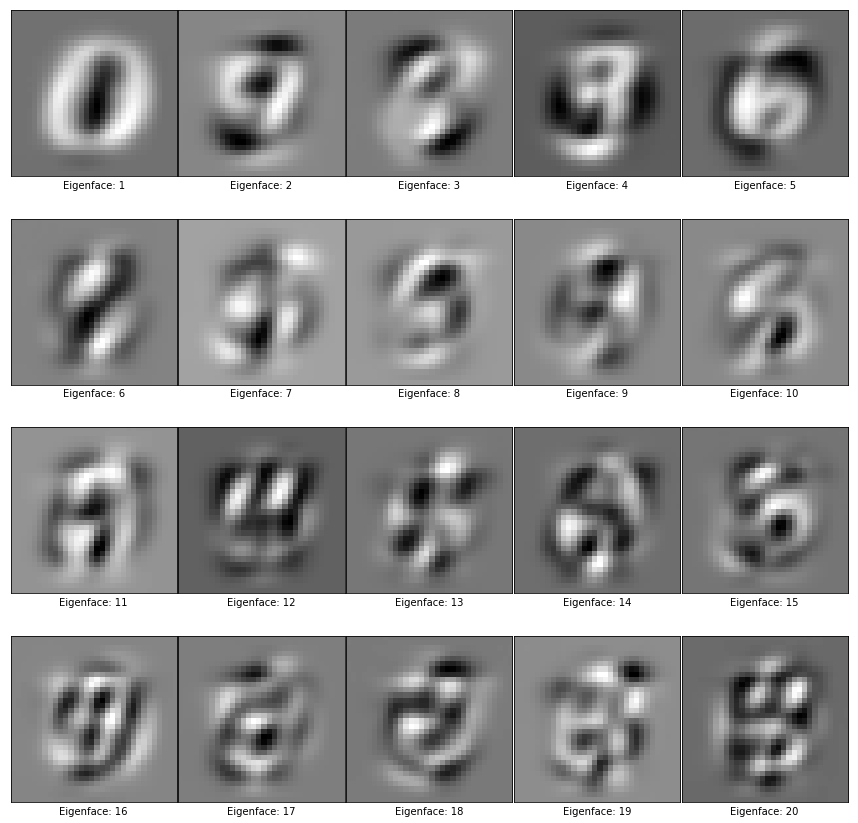

Below is a comparison between the original and the reconstructed data


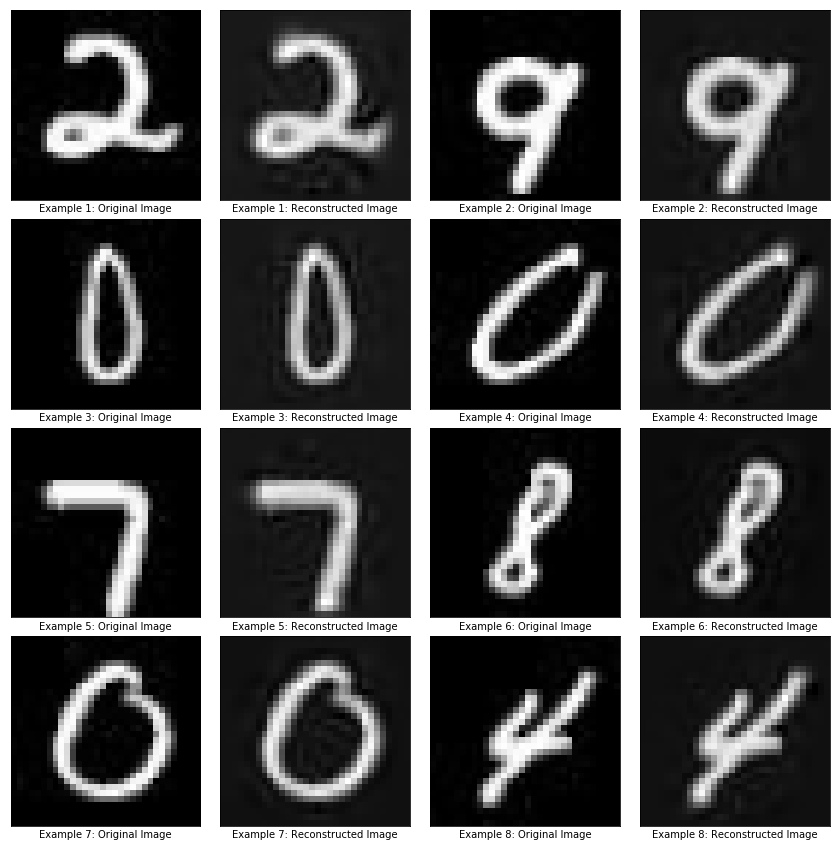

In [5]:
# Compute PCA with training dataset
imgs_train_pca,pca_matrix, component_mean = pca_all_processes(imgs_train,labels_train,n_components, plot_eigenfaces_bool = True,plot_comparison_bool = True, height=height,width=width)

# Reconstruct the test set
imgs_test_pca = reconstruct_with_pca(imgs_test, component_mean,pca_matrix,n_components)

### Anomaly Detection with Reconstruction Error on PCA

In [6]:
imgs_train.shape,imgs_train_pca.shape,imgs_test.shape,imgs_test_pca.shape

((60000, 1024), (60000, 1024), (10000, 1024), (10000, 1024))

The higher the reconstruction error, the more likely the point will be an anomaly


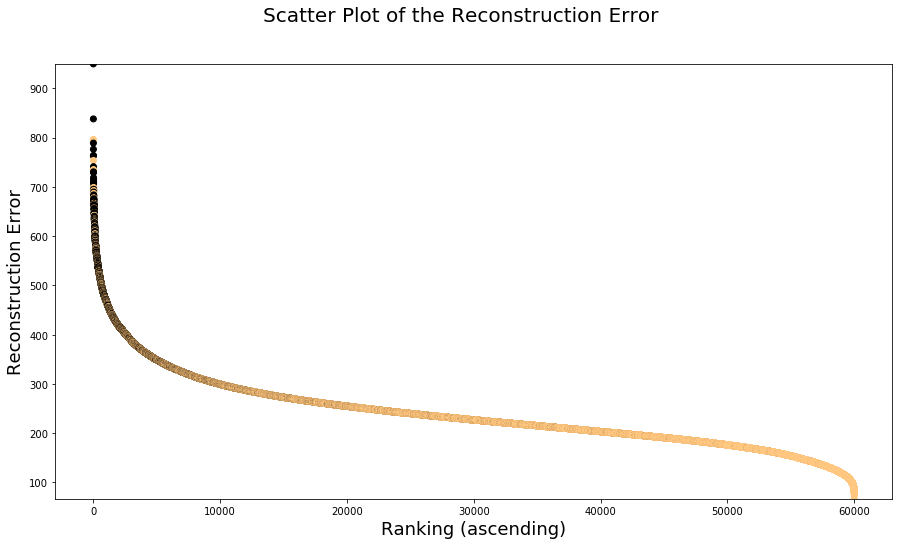

Training Results:
Precision: 42.5%
Recall: 57.6%
F-score: 48.9%
R-Precision (# R = 5958.0): 47.8%
Precision@20: 75.0%

Testing Results:
Precision: 43.5%
Recall: 53.3%
F-score: 46.4%
R-Precision (# R = 1032.0): 47.2%
Precision@20: 80.0%


In [7]:
train_test_with_reconstruction_error(imgs_train, imgs_train_pca, imgs_test, imgs_test_pca, labels_train, labels_test,k)